## 导入包和数据

In [61]:
from VE_LSH import LSH
from CF import CF
from vector_encrypt import vector_encrypt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from laplace_dp import laplace_dp
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

original_data = pd.read_table('../GIS_LSH_VE_CF/data/train.csv',sep=",",names=['latitude','longitude'],encoding='latin-1',engine='python')
user_mx = pd.read_table('../GIS_LSH_VE_CF/data/user_mx.csv',sep=",",names=['latitude','longitude'],encoding='latin-1',engine='python')
test_data = pd.read_table('../GIS_LSH_VE_CF/data/test.csv',sep=",",names=['latitude','longitude'],encoding='latin-1',engine='python')
data = test_data.groupby(test_data.index).mean()
# data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,0,0
# data = pd.read_table('./GIS_LSH_VE_CF/data/predict_data.csv',sep=",",names=['latitude','longitude','predict_latitude','predict_longitude','la_MAE','long_MAE'],encoding='latin-1',engine='python')
# print(data)
# 对用户矩阵进行预处理，将str转换为list
def to_list(str):
    return [ float(x) for x in str[1:-2].split(',')]
user_mx['latitude'] = user_mx['latitude'].apply(to_list)
user_mx['longitude'] = user_mx['longitude'].apply(to_list)

## 训练函数

In [62]:
def train_CF(train_data,test_data):
    global data,cf_cal
    trainIndex,testIndex,topk,count = train_data.index,test_data.index,3,0
    length = len(testIndex)
    start_time = time.time()
    for i in testIndex:
        count += 1
        #print("当前进度是:",count/length)
        sim_lis = []
        for j in trainIndex:
            if i == j:
                continue
            sim_lis.append(cf_cal.calSim(i,j))
        te = sorted(sim_lis,key=lambda x:x[1],reverse=True)[1:topk]
        cf_cal.cf_mae(i,te)
    end_time = time.time()
    la_mae,long_mae = data['la_MAE'].mean(),data['long_MAE'].mean()
    mean_mae = (la_mae+long_mae)/2
    print('测试集long_mae为{0},测试集la_mae为{1},测试集mean_mae为{2}'.format(long_mae,la_mae,mean_mae))
    return mean_mae,end_time-start_time

In [63]:
def train_LSH(test_data,te_lshTable,lshTable,is_laplace=False): # is_laplace:是否加入拉普拉斯噪声进行隐私保护
    global data,lsh_cal
    testIndex = test_data.index
    topk,count,length,num = 3,0,len(testIndex),-1
    # print("测试集LSH为:",lsh_cal.lsh_detect(te_lshTable))
    # print("训练集集LSH为:",lsh_cal.lsh_detect(lshTable))
    start_time = time.time()
    for table_num in te_lshTable.values(): # 遍历测试集的每个表,这里默认设置的一个表
        num += 1
        print("当前表数为:",num)
        for buckets in table_num: # 遍历当前表的hash桶
            if buckets not in lshTable[num].keys():
                    continue
            for test_id in te_lshTable[num][buckets]: # 遍历当前表当前桶里的测试集用户和训练集用户
                count += 1
                #print("当前进度是:",count/length)
                sim_lis = []
                
                for train_id in lshTable[num][buckets]: # 遍历训练集hash映射后同一个表，同一个桶下的数据
                    sim_lis.append(lsh_cal.calSim(test_id,train_id,is_laplace))
                te = sorted(sim_lis,key=lambda x:x[1],reverse=True)[2:topk]
                lsh_cal.lsh_mae(test_id,te)
    end_time = time.time()
    la_mae,long_mae = data['la_MAE'].mean(),data['long_MAE'].mean()
    mean_mae = (la_mae+long_mae)/2
    print('测试集long_mae为{0},测试集la_mae为{1},测试集mean_mae为{2}'.format(long_mae,la_mae,mean_mae))
    return mean_mae,end_time-start_time

In [64]:
def train_encrypt_LSH(test_data,te_lshTable,lshTable):
    global data,lsh_cal
    testIndex = test_data.index
    topk,count,length,num = 3,0,len(testIndex),-1
    # print("测试集LSH为:",lsh_cal.lsh_detect(te_lshTable))
    # print("训练集集LSH为:",lsh_cal.lsh_detect(lshTable))
    res_time = 0
    start_time = time.time()
    for table_num in te_lshTable.values(): # 遍历测试集的每个表,这里默认设置的一个表
        num += 1
        print("当前表数为:",num)
        for buckets in table_num: # 遍历当前表的hash桶
            if buckets not in lshTable[num].keys():
                    continue
            for test_id in te_lshTable[num][buckets]: # 遍历当前表当前桶里的测试集用户和训练集用户
                count += 1
                #print("当前进度是:",count/length)
                sim_lis = []
                end_time = time.time()
                res_time += end_time-start_time
                for train_id in lshTable[num][buckets]: # 遍历训练集hash映射后同一个表，同一个桶下的数据
                    sim_res,time_count = lsh_cal.encrypt_calSim(test_id,train_id)
                    res_time += time_count
                    sim_lis.append(sim_res)
                start_time = time.time()
                te = sorted(sim_lis,key=lambda x:x[1],reverse=True)[2:topk]
                lsh_cal.lsh_mae(test_id,te)
                end_time = time.time()
                res_time += end_time-start_time
    la_mae,long_mae = data['la_MAE'].mean(),data['long_MAE'].mean()
    mean_mae = (la_mae+long_mae)/2
    print('测试集long_mae为{0},测试集la_mae为{1},测试集mean_mae为{2}'.format(long_mae,la_mae,mean_mae))
    return mean_mae,res_time

## 参数和实例化

In [65]:
data_item = [2000,4000,6000,8000,10000]
# 参数设置
mae,times = [],[]
nbits,num,d = 20,2,2
# 实例化
vec_encrypt = vector_encrypt()
lsh_cal = LSH(user_mx,data,vec_encrypt)
cf_cal = CF(user_mx,data)
times = {}
bits_dic = {}
for i in range(3):
    bits_dic[i],times[i] = [],[]

## 根据不同数据量进行比较

### CF

In [66]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,0,0
start,total_time = 0, 0
for i in data_item:
    print("当前数据切片是:",i)
    train_data = original_data.iloc[start:i]
    cf_mean_mae,cf_time = train_CF(train_data,test_data)
    total_time += cf_time
    bits_dic[0].append(cf_mean_mae),times[0].append(total_time)
    start += 2000


当前数据切片是: 2000
测试集long_mae为3.728709348156871,测试集la_mae为1.6613124390532001,测试集mean_mae为2.6950108936050357
当前数据切片是: 4000
测试集long_mae为2.333868059998691,测试集la_mae为0.9882883014188104,测试集mean_mae为1.661078180708751
当前数据切片是: 6000
测试集long_mae为1.8473497476521872,测试集la_mae为0.7641078293039368,测试集mean_mae为1.305728788478062
当前数据切片是: 8000
测试集long_mae为1.329463698356682,测试集la_mae为0.5886651461081138,测试集mean_mae为0.959064422232398
当前数据切片是: 10000
测试集long_mae为1.0849109526244736,测试集la_mae为0.48662913129836627,测试集mean_mae为0.78577004196142


### LSH

In [67]:

data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,0,0
hash_func = lsh_cal.hash_function(num,nbits,d) # hash映射函数
start,total_time = 0,0
for i in data_item:
    print("当前数据切片是:",i)
    train_data = original_data.iloc[start:i]
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_mae,lsh_time = train_LSH(train_data,te_lshTable,lshTable)
    total_time += lsh_time
    bits_dic[1].append(lsh_mae),times[1].append(total_time)
    start += 2000

当前数据切片是: 2000
当前表数为: 0
down is 0
down is 0
当前表数为: 1
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
测试集long_mae为3.658847647217999,测试集la_mae为1.6547206086786503,测试集mean_mae为2.656784127948325
当前数据切片是: 4000
当前表数为: 0
down is 0
down is 0
down is 0
当前表数为: 1
down is 0
down is 0
down is 0
测试集long_mae为2.2635757119973494,测试集la_mae为0.9896373978949,测试集mean_mae为1.6266065549461248
当前数据切片是: 6000
当前表数为: 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
当前表数为: 1
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
测试集long_mae为1.8078536290537999,测试集la_mae为0.7655219799638501,测试集mean_mae为1.286687804508825
当前数据切片是: 8000
当前表数为: 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
当前表数

### ELSH

In [68]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,0,0
start,total_time = 0,0
for i in data_item:
    print("当前数据切片是:",i)
    train_data = original_data.iloc[start:i]
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_encrypt_mae,lsh_encrypt_time = train_encrypt_LSH(test_data,te_lshTable,lshTable)
    total_time += lsh_encrypt_time
    bits_dic[2].append(lsh_encrypt_mae),times[2].append(total_time)
    start += 2000


当前数据切片是: 2000
当前表数为: 0
down is 0
down is 0
当前表数为: 1
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
测试集long_mae为3.7073908348781996,测试集la_mae为1.66983588756795,测试集mean_mae为2.6886133612230747
当前数据切片是: 4000
当前表数为: 0
down is 0
down is 0
down is 0
当前表数为: 1
down is 0
down is 0
down is 0
测试集long_mae为2.2878084133914,测试集la_mae为0.9972101343543,测试集mean_mae为1.64250927387285
当前数据切片是: 6000
当前表数为: 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
当前表数为: 1
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
测试集long_mae为1.8320327835158001,测试集la_mae为0.7730592723076499,测试集mean_mae为1.302546027911725
当前数据切片是: 8000
当前表数为: 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
down is 0
当前表数为: 1


## 绘图

各个算法的误差为:{0: [2.6950108936050357, 1.661078180708751, 1.305728788478062, 0.959064422232398, 0.78577004196142], 1: [2.656784127948325, 1.6266065549461248, 1.286687804508825, 1.090475350084425, 0.8677701116945999], 2: [2.6886133612230747, 1.64250927387285, 1.302546027911725, 1.106327935520575, 0.883603570520125]}
各个所用的时间为{0: [379.32889914512634, 764.2643761634827, 1175.7989473342896, 1559.0139877796173, 1934.7203288078308], 1: [72.31787586212158, 135.21740293502808, 214.49260234832764, 293.841189622879, 365.40583300590515], 2: [103.57593989372253, 194.49724173545837, 307.56843185424805, 520.6254773139954, 685.0465750694275]}


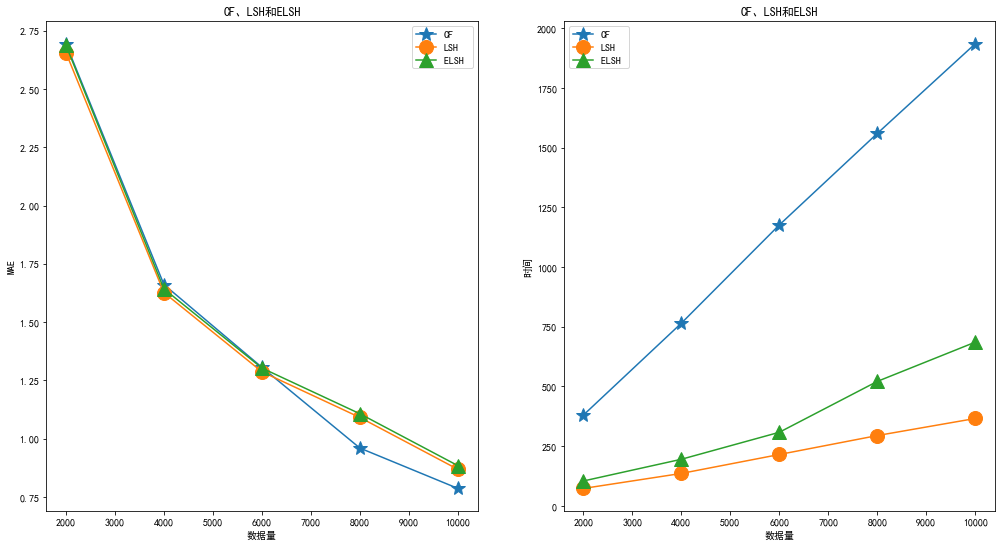

In [69]:
leg = []
leg.append("CF"),leg.append("LSH"),leg.append("ELSH ")
print("各个算法的误差为:{0}\n各个所用的时间为{1}".format(bits_dic,times))

style = ["*","o","^","s","X","<",">","p","h","1","2"]
plt.figure(1 , figsize = (17 , 9) )
plt.subplot(121)
for i in range(3):
    plt.plot(data_item,bits_dic[i],marker=style[i],markersize=14)
plt.xlabel("数据量"),plt.ylabel("MAE"),plt.title("CF、LSH和ELSH"),plt.legend(leg)

plt.subplot(122)
for i in range(3):
    plt.plot(data_item,times[i],marker=style[i],markersize=14)
plt.xlabel("数据量"),plt.ylabel("时间"),plt.title("CF、LSH和ELSH"),plt.legend(leg)
fig=plt.gcf()
fig.savefig('../GIS_LSH_VE_CF/picture//CF_LSH_ELSH1.jpg',dpi=500)
plt.show()